# Optymalizacja systemów i sieci informatycznych nowej generacji

Celem zadania jest przeprowadzenie porównania implementacji problemu rozmieszczenia sieci programowalnej zaimplementowanego na podstawie załączonego [artykułu](https://www.researchgate.net/publication/264625467_On_the_Capacitated_Controller_Placement_Problem_in_Software_Defined_Networks) oraz z wykorzystaniem biblioteki geeko. Zgodnie z ustalonymi wytycznymi, analiza obejmować będzie zmiany dwóch zmiennych które, dla których trzykrotnie zostaną rozpatrzone różne instancje problemu. Porównane zostaną otrzymane wyniki, skuteczność oraz czas działania algorytmów.

Rozpatrywanymi przez nas zmiennymi będą:
 - liczba switchy
 - pojemność kontrolerów 

Autorzy
 - Ewa Sakowicz
 - Piotr Krakowiak

## Implementacja logiki odpowiedzialnej za porównywanie rozwiązań 

Rozpocznijmy od zdefiniowania kilku wartości które pozostaną stałe na przestrzeni całej analizy.

In [1]:
number_of_maximum_active_controllers: int = 3
switch_load: int = 10
x_range: tuple = (0, 90)
y_range: tuple = (0, 180)

Następnie zdefinujmy zmienne które zostaną wykorzystane podczas analizy.

In [2]:
number_of_instances = 3
instances_switches = (4, 6, 8)

instance_capacities_1 = ([15, 15, 15, 15],
                         [45, 1, 1, 1],
                         [25, 1, 15, 1])

instance_capacities_2 = ([30, 30, 30, 30, 30, 30],
                         [90, 1, 1, 1, 1, 1],
                         [35, 1, 1, 1, 35, 35])

instance_capacities_3 = ([50, 50, 50, 50, 50, 50, 50, 50],
                         [150, 1, 1, 1, 1, 1, 1, 1],
                         [60, 1, 1, 1, 60, 1, 1, 60])

instances_capacities = [instance_capacities_1, instance_capacities_2, instance_capacities_3]

Kolejnym krokiem będzie stworzenie reużywalnej klasy reprezentującej instancje problemu która ułatwi nam przeprowadzenie porówań zaimplementowanych algorytmów. 

In [3]:
import random
import numpy as np

class ProblemInstance:
    number_of_switches: int
    switches: list
    switch_locations: list
    switches_loads: list
    distances: list
    controller_capacities: list

    def __init__(self, number_of_switches: int, controller_capacities: list) -> None:
        if len(controller_capacities) != number_of_switches:
            print(controller_capacities, number_of_switches)
            raise ValueError("Number of switches does not match with number of passed loads")

        self.number_of_switches = number_of_switches
        self.switches = self.initialize_switches(number_of_switches)
        self.switches_loads = self.initialize_switches_loads(number_of_switches)
        self.controller_capacities = controller_capacities
        self.switch_locations = self.initialize_switch_locations(number_of_switches)
        self.distances = self.initialize_distances()

    def initialize_switches(self, number_of_switches: int) -> list:
        return list(range(number_of_switches))

    def initialize_switches_loads(self, number_of_switches: int) -> list:
        return [switch_load] * number_of_switches
    
    def initialize_switch_locations(self, number_of_switches: int) -> list:
        locations = []
        for switch in range(number_of_switches):
            x = random.uniform(x_range[0], x_range[1])
            y = random.uniform(y_range[0], y_range[1])
            locations.append((x, y))
        return locations

    def initialize_distances(self) -> list:
        distances = np.zeros((len(self.switches), len(self.switches)))
        for i, switch_i in enumerate(self.switches):
            for j, switch_j in enumerate(self.switches):
                if i != j:
                    xi, yi = self.switch_locations[switch_i]
                    xj, yj = self.switch_locations[switch_j]
                    distance = np.sqrt((xi - xj) ** 2 + (yi - yj) ** 2)
                    distances[i][j] = distances[j][i] = distance
        return distances

    def print_instance(self) -> None:
        print(f'number of switches: {self.number_of_switches}, capacities: {self.controller_capacities}, loads: {self.switches_loads}')

Na podstawie zdefiniowanych zmiennych, możemy stworzyć kolejne instancje problemów

In [4]:
if len(instances_switches) != len(instances_capacities):
    raise ValueError("Number of instance switches does not match instances capacities")

instances = []
for instance_number in range(number_of_instances):
        switch_instance = []
        for capacity in instances_capacities[instance_number]:
            switch_instance.append(ProblemInstance(instances_switches[instance_number], capacity))
        instances.append(switch_instance)

In [5]:
for instance in instances:
    for switch_instance in instance:
        switch_instance.print_instance()

number of switches: 4, capacities: [15, 15, 15, 15], loads: [10, 10, 10, 10]
number of switches: 4, capacities: [45, 1, 1, 1], loads: [10, 10, 10, 10]
number of switches: 4, capacities: [25, 1, 15, 1], loads: [10, 10, 10, 10]
number of switches: 6, capacities: [30, 30, 30, 30, 30, 30], loads: [10, 10, 10, 10, 10, 10]
number of switches: 6, capacities: [90, 1, 1, 1, 1, 1], loads: [10, 10, 10, 10, 10, 10]
number of switches: 6, capacities: [35, 1, 1, 1, 35, 35], loads: [10, 10, 10, 10, 10, 10]
number of switches: 8, capacities: [50, 50, 50, 50, 50, 50, 50, 50], loads: [10, 10, 10, 10, 10, 10, 10, 10]
number of switches: 8, capacities: [150, 1, 1, 1, 1, 1, 1, 1], loads: [10, 10, 10, 10, 10, 10, 10, 10]
number of switches: 8, capacities: [60, 1, 1, 1, 60, 1, 1, 60], loads: [10, 10, 10, 10, 10, 10, 10, 10]


Posiadając rozpatrywane instancje możemy stworzyć funkcje które pozowolą nam na analize zaimplementowanych algorytmow.

In [6]:
from time import time
from implementations import geeko_implementation

def analyse_geeko():
    results = []
    for instance in instances:
        instance_results = []
        for switch_instance in instance:
            start_time = time()
            minimal_distance, number_of_controllers = geeko_implementation(
                switch_instance.number_of_switches,
                number_of_maximum_active_controllers,
                switch_instance.controller_capacities,
                switch_instance.switches_loads,
                switch_instance.distances,
                number_of_maximum_active_controllers)
            end_time = time()
            time_taken = end_time - start_time
            instance_results.append((time_taken, minimal_distance, number_of_controllers))
        results.append(instance_results)
    return results
                                                                              
geeko_results = analyse_geeko()

In [8]:
from implementations import article_implementation

def analyse_article():
    results = []
    for instance in instances:
        instance_results = []
        for switch_instance in instance:
            start_time = time()
            minimal_distance, number_of_controllers = article_implementation(
                switch_instance.number_of_switches,
                switch_instance.controller_capacities,
                switch_instance.switches_loads,
                switch_instance.distances,
                number_of_maximum_active_controllers)
            end_time = time()
            time_taken = end_time - start_time
            instance_results.append((time_taken, minimal_distance, number_of_controllers))
        results.append(instance_results)
    return results

article_results = analyse_article()

STEP 3 0.0 2.6666666667
4.0 3
Index issue
STEP 3 150.06565901272998 0.88888888889
1.0 3
STEP 3 30.738230583239236 2.0
4 3
Index issue
STEP 3 0.0 2.0
6.0 3
STEP 3 91.44423115265155 4.2002684454
4 3
STEP 3 43.302784159568716 1.7142857143
4 3
STEP 3 0.0 1.6
8.0 3
STEP 3 146.48661719405254 2.2054220709
4 3
STEP 3 23.533990394536254 1.4229248136
4 3


## Porównanie czasu wykonywania

In [10]:
import pandas as pd

columns = ("pojemności kontrolerów 1", "pojemności kontrolerów 2", "pojemności kontrolerów 3")
rows = ("geeko", "artykuł")

geeko_times = []
article_times = []

for result_number, result in enumerate(geeko_results):
    execution_times = []
    for case_result_number, case_result in enumerate(result):
        execution_times.append(result[case_result_number][0])
    geeko_times.append(execution_times)

for result_number, result in enumerate(article_results):
    execution_times = []
    for case_result_number, case_result in enumerate(result):
        execution_times.append(result[case_result_number][0])
    article_times.append(execution_times)


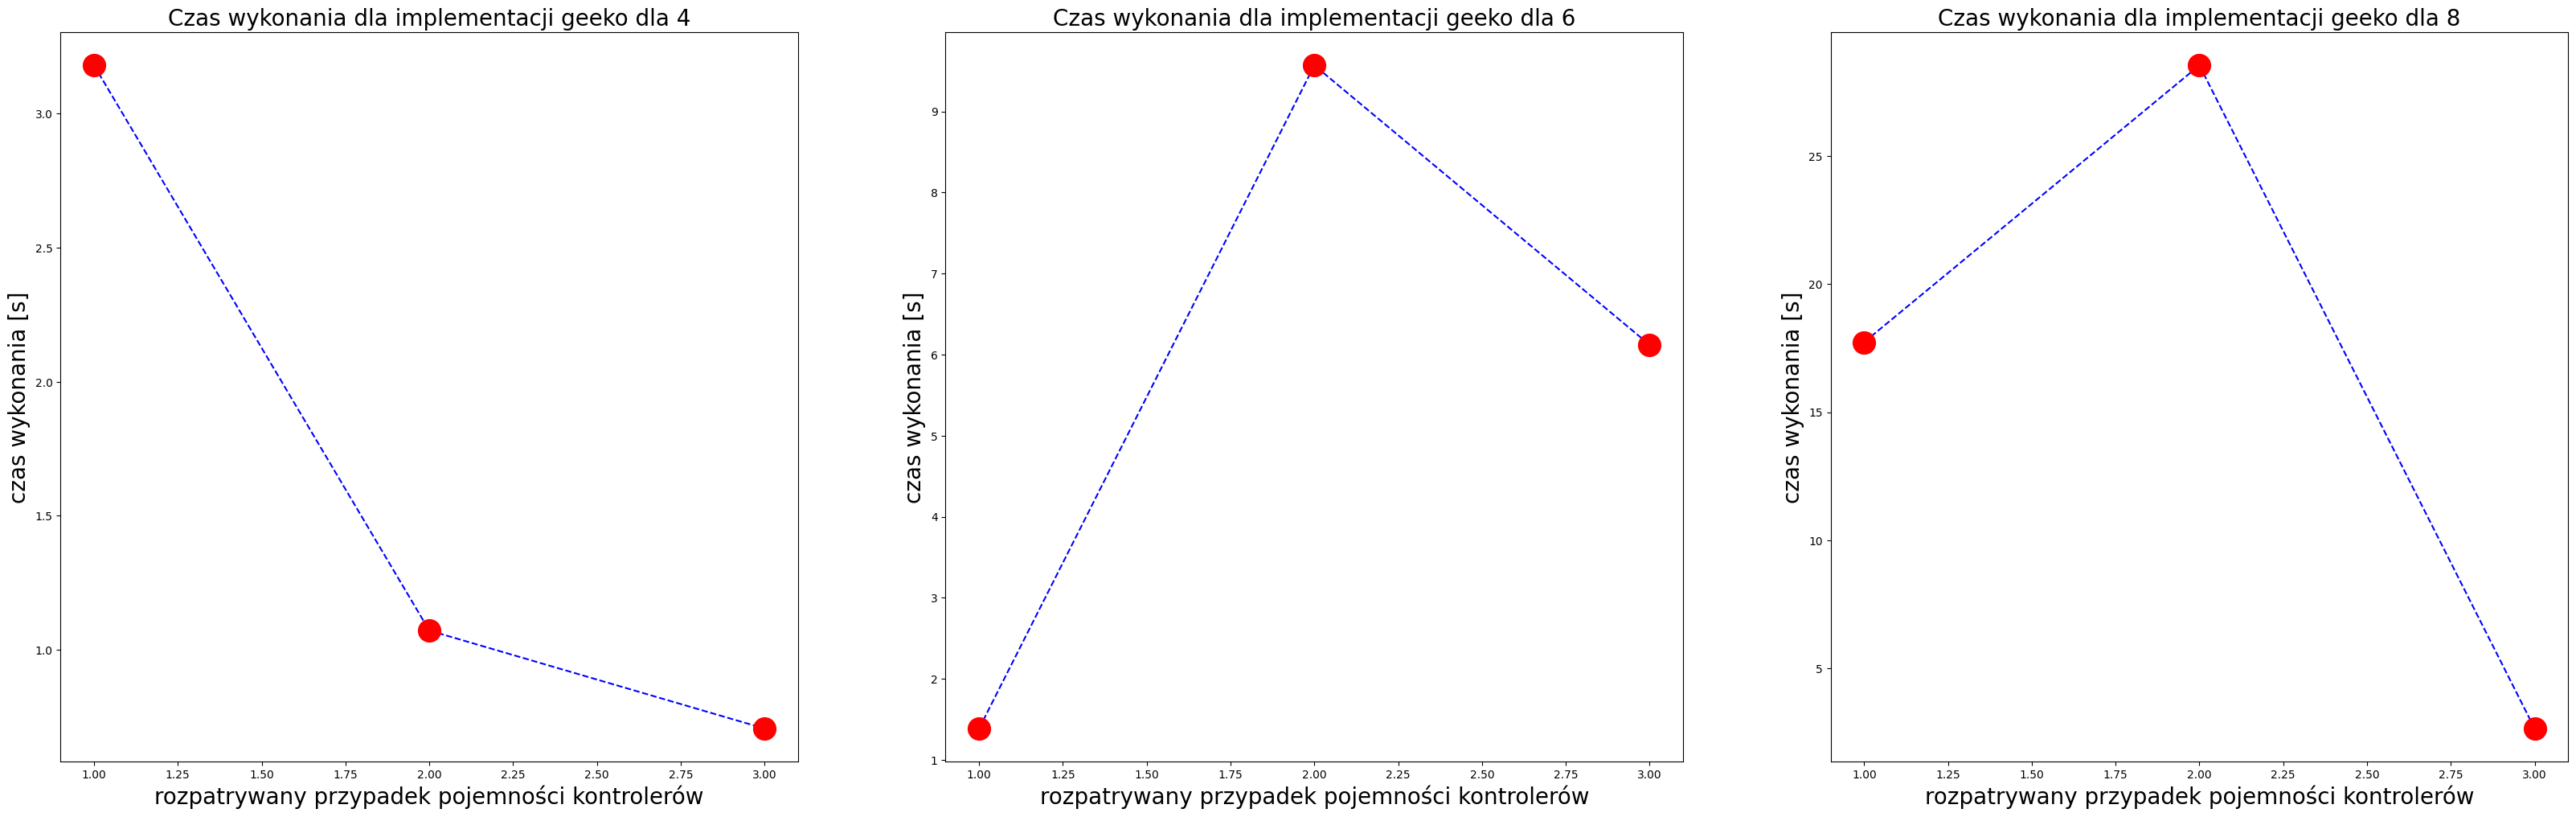

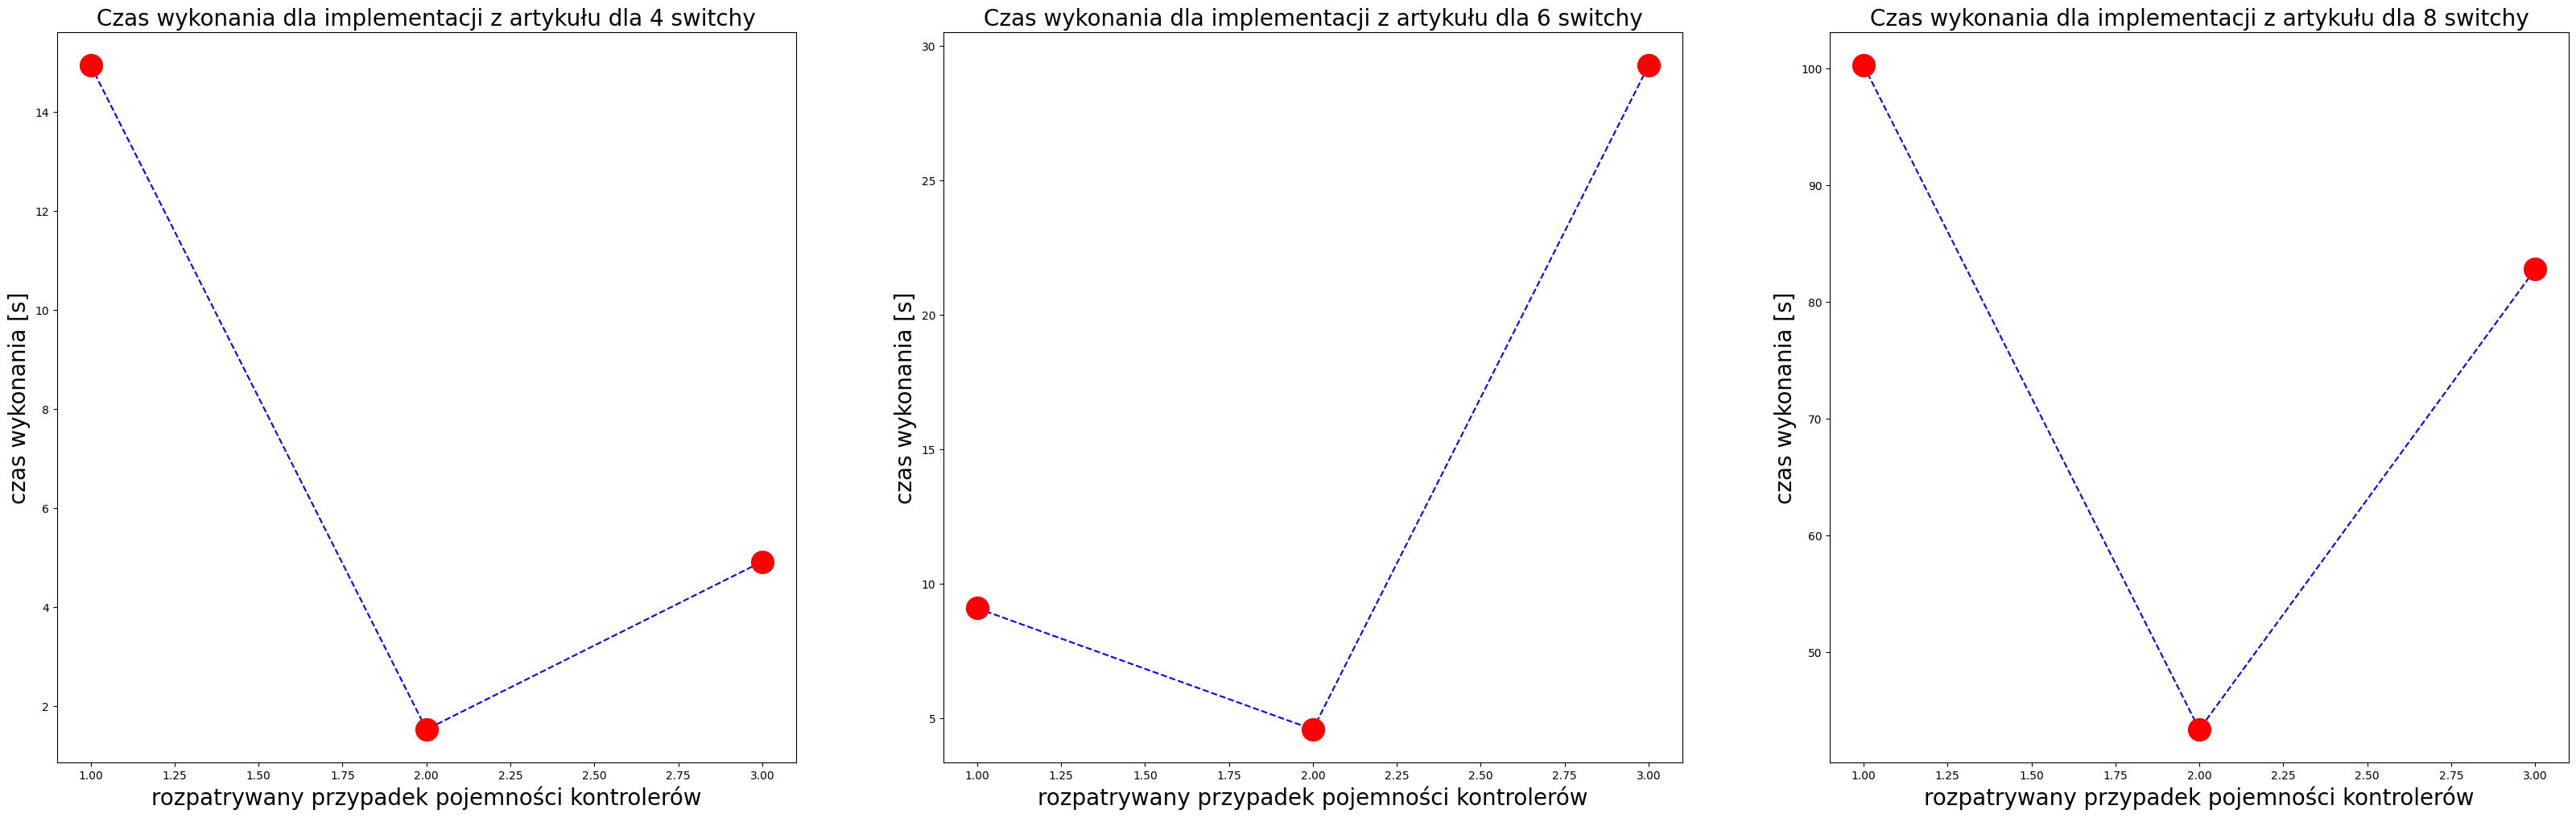

In [11]:
import matplotlib.pyplot as plt

if len(geeko_results) != len(article_results):
    raise ValueError("Invalid number of results")

x = [1, 2, 3]

for result_number, result in enumerate(geeko_results):
    y = [result[0][0], result[1][0], result[2][0]]
    plt.subplot(1, 3, result_number + 1)
    plt.title(f"Czas wykonania dla implementacji geeko dla {instances_switches[result_number]}", fontsize=20)
    plt.xlabel("rozpatrywany przypadek pojemności kontrolerów",fontsize=20)
    plt.ylabel("czas wykonania [s]", fontsize=20)
    plt.plot(x, y, marker="o" ,color="blue", markersize=20, mec = 'r', mfc = 'r', linestyle='dashed')
    
plt.subplots_adjust(top=2, right=5)
plt.show()

for result_number, result in enumerate(article_results):
    y = [result[0][0], result[1][0], result[2][0]]
    plt.subplot(1, 3, result_number + 1)
    plt.title(f"Czas wykonania dla implementacji z artykułu dla {instances_switches[result_number]} switchy", fontsize=20)
    plt.xlabel("rozpatrywany przypadek pojemności kontrolerów", fontsize=20)
    plt.ylabel("czas wykonania [s]", fontsize=20)
    plt.plot(x, y, marker="o" ,color="blue", markersize=20, mec = 'r', mfc = 'r', linestyle='dashed')
    
plt.subplots_adjust(top=2, right=5)
plt.show()  

Zestawienie czasów wykonywania algorymów dla 4 switchy [s].

In [12]:
pd.DataFrame([geeko_times[0], article_times[0]], rows, columns)

,pojemności kontrolerów 1,pojemności kontrolerów 2,pojemności kontrolerów 3
geeko,3.180362,1.072228,0.706675
artykuł,14.935009,1.534355,4.921605


Zestawienie czasów wykonywania algorymów dla 6 switchy [s].

In [13]:
pd.DataFrame([geeko_times[1], article_times[1]], rows, columns)

,pojemności kontrolerów 1,pojemności kontrolerów 2,pojemności kontrolerów 3
geeko,1.387279,9.568202,6.120603
artykuł,9.099148,4.591084,29.283355


Zestawienie czasów wykonywania algorymów dla 8 switchy [s].

In [14]:
pd.DataFrame([geeko_times[2], article_times[2]], rows, columns)

,pojemności kontrolerów 1,pojemności kontrolerów 2,pojemności kontrolerów 3
geeko,17.732052,28.538548,2.651397
artykuł,100.242597,43.396652,82.788989


## Porównanie minimalnego promienia

In [15]:
geeko_radiuses = []
article_radiuses = []

for result_number, result in enumerate(geeko_results):
    radiuses = []
    for case_result_number, case_result in enumerate(result):
        radiuses.append(result[case_result_number][1])
    geeko_radiuses.append(radiuses)

for result_number, result in enumerate(article_results):
    radiuses = []
    for case_result_number, case_result in enumerate(result):
        radiuses.append(result[case_result_number][1])
    article_radiuses.append(radiuses)

Zestawienie minimalnych promieni algorymów dla 4 switchy.

In [16]:
pd.DataFrame([geeko_radiuses[0], article_radiuses[0]], rows, columns)

,pojemności kontrolerów 1,pojemności kontrolerów 2,pojemności kontrolerów 3
geeko,NaN,312.522461,NaN
artykuł,0.0,150.065659,30.738231


Zestawienie minimalnych promieni algorymów dla 6 switchy.

In [17]:
pd.DataFrame([geeko_radiuses[1], article_radiuses[1]], rows, columns)

,pojemności kontrolerów 1,pojemności kontrolerów 2,pojemności kontrolerów 3
geeko,45.058386,348.150083,251.576886
artykuł,0.000000,91.444231,43.302784


Zestawienie minimalnych promieni algorymów dla 8 switchy.

In [18]:
pd.DataFrame([geeko_radiuses[2], article_radiuses[2]], rows, columns)

,pojemności kontrolerów 1,pojemności kontrolerów 2,pojemności kontrolerów 3
geeko,193.352599,863.427577,172.719091
artykuł,0.000000,146.486617,23.533990


## Porównanie liczby aktywnych kontrolerów

In [19]:
geeko_controllers = []
article_controllers = []

for result_number, result in enumerate(geeko_results):
    controllers = []
    for case_result_number, case_result in enumerate(result):
        controllers.append(result[case_result_number][2])
    geeko_controllers.append(controllers)

for result_number, result in enumerate(article_results):
    controllers = []
    for case_result_number, case_result in enumerate(result):
        controllers.append(result[case_result_number][2])
    article_controllers.append(controllers)

Zestawienie liczby aktywnych kontrolerów dla 4 switchy.

In [20]:
pd.DataFrame([geeko_controllers[0], article_controllers[0]], rows, columns)

,pojemności kontrolerów 1,pojemności kontrolerów 2,pojemności kontrolerów 3
geeko,NaN,3.0,NaN
artykuł,4.0,1.0,4.0


Zestawienie liczby aktywnych kontrolerów dla 6 switchy.

In [21]:
pd.DataFrame([geeko_controllers[1], article_controllers[1]], rows, columns)

,pojemności kontrolerów 1,pojemności kontrolerów 2,pojemności kontrolerów 3
geeko,3.0,3.0,3.0
artykuł,3.0,1.0,3.0


Zestawienie liczby aktywnych kontrolerów dla 8 switchy.

In [22]:
pd.DataFrame([geeko_controllers[2], article_controllers[2]], rows, columns)

,pojemności kontrolerów 1,pojemności kontrolerów 2,pojemności kontrolerów 3
geeko,3.0,3.0,3.0
artykuł,3.0,1.0,3.0
